# One-at-a-time Sensitivity Analysis

Using the models we have previously trained (SVM and k-NN) on Rashid's dataset, we will now __systematically remove features__ from the dataset and see how the performance of our classifiers changes. 

The goal is to find which features provide the most 'bang for our buck', by removing unnecessary features that do not effect the performance of the accuracy of our machine learning model to predict near native structures.

## Load the Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('1mii_ML.csv')

column_names = df.columns[0:len(df.columns) - 1]
print(column_names)

df.head()

Index(['Frame', 'Hbonds', 'Molsurf', 'RMSD', 'ROG', 'end-to-end',
       'energy_angle', 'energy_bond', 'energy_dihedral', 'energy_elec',
       'energy_elec14', 'energy_gb', 'energy_vdw', 'energy_vdw14', 'ss_3-10',
       'ss_APBS', 'ss_PBS', 'ss_alpha', 'ss_bend', 'ss_none', 'ss_pi'],
      dtype='object')


,Frame,Hbonds,Molsurf,RMSD,ROG,end-to-end,energy_angle,energy_bond,energy_dihedral,energy_elec,...,energy_vdw,energy_vdw14,ss_3-10,ss_APBS,ss_PBS,ss_alpha,ss_bend,ss_none,ss_pi,ss_turn
0,0,4,698.912338,4.234889,6.584806,10.671312,123.723222,31.631192,212.147892,-1112.125804,...,-82.217559,38.940037,0.0,0.0,0,29.411765,11.764706,47.058824,0.0,11.764706
1,1,2,710.001821,4.226051,6.681199,10.874207,122.684917,36.635134,205.920390,-1120.472605,...,-81.428032,37.335000,0.0,0.0,0,29.411765,11.764706,47.058824,0.0,11.764706
2,2,2,722.223469,4.246277,6.613796,10.715682,119.322729,27.421875,207.357482,-1101.946781,...,-85.804202,43.409406,0.0,0.0,0,29.411765,11.764706,47.058824,0.0,11.764706
3,3,1,731.405021,4.382348,6.619212,10.855698,124.979237,29.662107,207.311274,-1106.488020,...,-81.468523,37.548546,0.0,0.0,0,23.529412,11.764706,47.058824,0.0,17.647059
4,4,2,707.606087,4.199144,6.587362,10.151879,122.256788,25.553019,215.603360,-1106.309467,...,-87.046542,39.587838,0.0,0.0,0,23.529412,11.764706,47.058824,0.0,17.647059


## Define the classes

We define structures that have RMSD < 1.5 angstorms as "Near Native" structures, and RMSD values greater or equal to 1.5 as "Far Native" structures.

We then remove the RMSD column, effectively replacing it with the Class column. 

In [2]:
c = []

for row in df['RMSD']:
    if row < 1.5:
        c.append('Near Native')
    else:
        c.append('Far Native')

df['Class'] = c # Add classes column to the last column of the dataframe
del df['RMSD']

df.head()    

,Frame,Hbonds,Molsurf,ROG,end-to-end,energy_angle,energy_bond,energy_dihedral,energy_elec,energy_elec14,...,energy_vdw14,ss_3-10,ss_APBS,ss_PBS,ss_alpha,ss_bend,ss_none,ss_pi,ss_turn,Class
0,0,4,698.912338,6.584806,10.671312,123.723222,31.631192,212.147892,-1112.125804,712.598326,...,38.940037,0.0,0.0,0,29.411765,11.764706,47.058824,0.0,11.764706,Far Native
1,1,2,710.001821,6.681199,10.874207,122.684917,36.635134,205.920390,-1120.472605,712.279466,...,37.335000,0.0,0.0,0,29.411765,11.764706,47.058824,0.0,11.764706,Far Native
2,2,2,722.223469,6.613796,10.715682,119.322729,27.421875,207.357482,-1101.946781,715.368704,...,43.409406,0.0,0.0,0,29.411765,11.764706,47.058824,0.0,11.764706,Far Native
3,3,1,731.405021,6.619212,10.855698,124.979237,29.662107,207.311274,-1106.488020,707.667941,...,37.548546,0.0,0.0,0,23.529412,11.764706,47.058824,0.0,17.647059,Far Native
4,4,2,707.606087,6.587362,10.151879,122.256788,25.553019,215.603360,-1106.309467,712.102749,...,39.587838,0.0,0.0,0,23.529412,11.764706,47.058824,0.0,17.647059,Far Native


## Preprocessing
* Define features and targets
* Standardiztion

In [3]:
y = df['Class'] # target variable is predicting the class of the structure (far native/ near native)

X = df
del X['Class'] # the features will be everything except the class column (and the RMSD column)
X.head() 

,Frame,Hbonds,Molsurf,ROG,end-to-end,energy_angle,energy_bond,energy_dihedral,energy_elec,energy_elec14,...,energy_vdw,energy_vdw14,ss_3-10,ss_APBS,ss_PBS,ss_alpha,ss_bend,ss_none,ss_pi,ss_turn
0,0,4,698.912338,6.584806,10.671312,123.723222,31.631192,212.147892,-1112.125804,712.598326,...,-82.217559,38.940037,0.0,0.0,0,29.411765,11.764706,47.058824,0.0,11.764706
1,1,2,710.001821,6.681199,10.874207,122.684917,36.635134,205.920390,-1120.472605,712.279466,...,-81.428032,37.335000,0.0,0.0,0,29.411765,11.764706,47.058824,0.0,11.764706
2,2,2,722.223469,6.613796,10.715682,119.322729,27.421875,207.357482,-1101.946781,715.368704,...,-85.804202,43.409406,0.0,0.0,0,29.411765,11.764706,47.058824,0.0,11.764706
3,3,1,731.405021,6.619212,10.855698,124.979237,29.662107,207.311274,-1106.488020,707.667941,...,-81.468523,37.548546,0.0,0.0,0,23.529412,11.764706,47.058824,0.0,17.647059
4,4,2,707.606087,6.587362,10.151879,122.256788,25.553019,215.603360,-1106.309467,712.102749,...,-87.046542,39.587838,0.0,0.0,0,23.529412,11.764706,47.058824,0.0,17.647059


In [4]:
from sklearn.preprocessing import StandardScaler

rescaledX = StandardScaler().fit_transform(X)
X = pd.DataFrame(data = rescaledX, columns= X.columns) # transform features using standardization
X.head()

,Frame,Hbonds,Molsurf,ROG,end-to-end,energy_angle,energy_bond,energy_dihedral,energy_elec,energy_elec14,...,energy_vdw,energy_vdw14,ss_3-10,ss_APBS,ss_PBS,ss_alpha,ss_bend,ss_none,ss_pi,ss_turn
0,-1.732033,1.250766,-0.578035,-1.486130,0.209753,-1.623187,-1.643516,0.016896,-1.388477,1.513560,...,-1.017536,-0.793378,-0.494948,-0.091513,0.0,0.469476,-0.781074,1.915769,-0.089135,-0.715461
1,-1.731999,-0.223742,-0.120379,-1.018724,0.302680,-1.718527,-0.836015,-0.918655,-1.624248,1.489597,...,-0.869041,-1.332333,-0.494948,-0.091513,0.0,0.469476,-0.781074,1.915769,-0.089135,-0.715461
2,-1.731964,-0.223742,0.383999,-1.345560,0.230075,-2.027253,-2.322785,-0.702762,-1.100952,1.721766,...,-1.692118,0.707390,-0.494948,-0.091513,0.0,0.469476,-0.781074,1.915769,-0.089135,-0.715461
3,-1.731930,-0.960996,0.762916,-1.319296,0.294202,-1.507856,-1.961272,-0.709704,-1.229227,1.143021,...,-0.876657,-1.260626,-0.494948,-0.091513,0.0,-0.005861,-0.781074,1.915769,-0.089135,-0.223218
4,-1.731895,-0.223742,-0.219250,-1.473739,-0.028149,-1.757839,-2.624368,0.536007,-1.224184,1.476316,...,-1.925779,-0.575853,-0.494948,-0.091513,0.0,-0.005861,-0.781074,1.915769,-0.089135,-0.223218


## Train Models

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.33,
                                                   random_state=123)

In [7]:
from sklearn.neighbors import KNeighborsClassifier

models = []
models.append(("k-Nearest Neighbour",KNeighborsClassifier()))

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

results = []
names = []
for name,model in models:
    kfold = KFold(n_splits=10, random_state=22)
    cv_result = cross_val_score(model, X_train, y_train, cv = kfold,scoring = "accuracy")
    names.append(name)
    results.append(cv_result)
    
for i in range(len(names)):
    print("%20s | Accuracy: %0.2f%% (+/- %0.2f%%)" % (names[i], 100*results[i].mean(), 100*results[i].std() * 2))

## Comparing Features

Here we will keep all the features, but for each box plot we will remove 1 feature (column) from our datast. We will then train the models again using these new datasets, and then rank the performance of how accurately the models distinguishes between near native and far native structures.

In [ ]:
X.head()

In [5]:
X.head()

,Frame,Hbonds,Molsurf,ROG,end-to-end,energy_angle,energy_bond,energy_dihedral,energy_elec,energy_elec14,...,energy_vdw,energy_vdw14,ss_3-10,ss_APBS,ss_PBS,ss_alpha,ss_bend,ss_none,ss_pi,ss_turn
0,-1.732033,1.250766,-0.578035,-1.486130,0.209753,-1.623187,-1.643516,0.016896,-1.388477,1.513560,...,-1.017536,-0.793378,-0.494948,-0.091513,0.0,0.469476,-0.781074,1.915769,-0.089135,-0.715461
1,-1.731999,-0.223742,-0.120379,-1.018724,0.302680,-1.718527,-0.836015,-0.918655,-1.624248,1.489597,...,-0.869041,-1.332333,-0.494948,-0.091513,0.0,0.469476,-0.781074,1.915769,-0.089135,-0.715461
2,-1.731964,-0.223742,0.383999,-1.345560,0.230075,-2.027253,-2.322785,-0.702762,-1.100952,1.721766,...,-1.692118,0.707390,-0.494948,-0.091513,0.0,0.469476,-0.781074,1.915769,-0.089135,-0.715461
3,-1.731930,-0.960996,0.762916,-1.319296,0.294202,-1.507856,-1.961272,-0.709704,-1.229227,1.143021,...,-0.876657,-1.260626,-0.494948,-0.091513,0.0,-0.005861,-0.781074,1.915769,-0.089135,-0.223218
4,-1.731895,-0.223742,-0.219250,-1.473739,-0.028149,-1.757839,-2.624368,0.536007,-1.224184,1.476316,...,-1.925779,-0.575853,-0.494948,-0.091513,0.0,-0.005861,-0.781074,1.915769,-0.089135,-0.223218


## Literally just 1 Feature at a Time

Rather than removing one feature at a time, we will instead just use 1 feature at a time to train our model. We train our model using only 1 feature, to predict the class.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [8]:
import numpy as np

f = []
s = []

for feature in X:
    
    """ remove the feature """
    one_feature = X[feature] # creates a new dataframe with just 1 feature
    one_feature = one_feature[:, np.newaxis] # scikit learn expects data to be 2 dimensional, add new empty column

    f.append(feature)
    
    """ train the model """
    # train the model using the new dataframe with just 1 feature removed
    
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(one_feature, y,
                                                        test_size=0.33,
                                                        random_state=123)

    from sklearn.model_selection import KFold
    from sklearn.model_selection import cross_val_score
    
    models = []
    models.append(("k-Nearest Neighbour",KNeighborsClassifier()))
    
    results = []
    names = []
    for name,model in models:
        kfold = KFold(n_splits=10, random_state=22)
        cv_result = cross_val_score(model, X_train, y_train, cv = kfold,scoring = "accuracy")
        names.append(name)
        results.append(cv_result)
    
    for i in range(len(names)):
        print("%20s | Accuracy: %0.2f%% (+/- %0.2f%%)" % (feature, 100*results[i].mean(), 100*results[i].std() * 2))
        s.append(results[i])

    
    # train model
    # return performance, add to a list the score and the feature removed
    # plot performance of list    

               Frame | Accuracy: 96.74% (+/- 0.44%)
              Hbonds | Accuracy: 94.76% (+/- 0.45%)
             Molsurf | Accuracy: 94.55% (+/- 0.51%)
                 ROG | Accuracy: 94.61% (+/- 0.45%)
          end-to-end | Accuracy: 94.29% (+/- 0.55%)
        energy_angle | Accuracy: 94.65% (+/- 0.43%)
         energy_bond | Accuracy: 94.65% (+/- 0.42%)
     energy_dihedral | Accuracy: 94.62% (+/- 0.48%)
         energy_elec | Accuracy: 94.53% (+/- 0.54%)
       energy_elec14 | Accuracy: 94.63% (+/- 0.52%)
           energy_gb | Accuracy: 94.45% (+/- 0.46%)
          energy_vdw | Accuracy: 94.67% (+/- 0.45%)
        energy_vdw14 | Accuracy: 94.66% (+/- 0.48%)
             ss_3-10 | Accuracy: 94.76% (+/- 0.45%)
             ss_APBS | Accuracy: 94.76% (+/- 0.45%)
              ss_PBS | Accuracy: 94.76% (+/- 0.45%)
            ss_alpha | Accuracy: 94.76% (+/- 0.45%)
             ss_bend | Accuracy: 94.76% (+/- 0.45%)
             ss_none | Accuracy: 94.76% (+/- 0.45%)
            

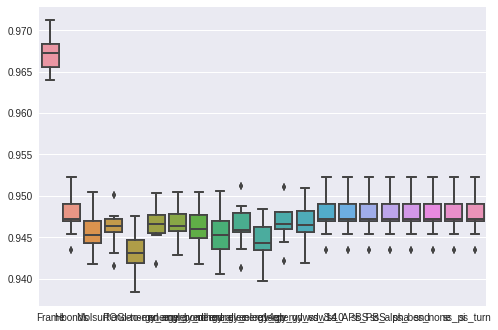

In [16]:
ax = sns.boxplot(data=s)
ax.set_xticklabels(f)
    
plt.show()

In [ ]:
# keep RMSD column, and see how this compares with the others. it should be 100%